# Notebook 00: Invariance and Baselines

## The Foundation of Model Understanding

Before we dive into the sophisticated techniques of model interpretability, we must establish a solid foundation. This notebook introduces two fundamental concepts that every data scientist should understand:

1. **Invariance**: The principle that well-behaved models should produce consistent predictions regardless of row order
2. **Baselines**: Simple reference models that help us understand what "random" or "naive" performance looks like

Understanding these concepts is crucial because they form the bedrock upon which all interpretability techniques are built. If a model isn't invariant to row shuffling, something is fundamentally wrong. If we don't know our baseline performance, we can't judge whether our model is actually learning anything useful.

---

## What is Invariance?

In machine learning, **invariance** refers to the property that certain transformations of the input data should not change the model's predictions. For tabular data models (like linear regression, random forests, gradient boosting), one of the most basic invariances is **row-order invariance**.

### Why Row Order Shouldn't Matter

Consider a dataset of patient records. Whether we arrange patients alphabetically, by age, or completely randomly, a well-trained model should produce the same predictions for the same patients. The model learns patterns from the **features**, not from the **order** in which examples appear.

Mathematically, if we have:
- Original dataset: $X = [x_1, x_2, ..., x_n]^T$ with predictions $\hat{y} = [\hat{y}_1, \hat{y}_2, ..., \hat{y}_n]$
- Permuted dataset: $X_{\pi} = [x_{\pi(1)}, x_{\pi(2)}, ..., x_{\pi(n)}]^T$ with predictions $\hat{y}_{\pi}$

Then for a row-order invariant model: $\hat{y}_{\pi(i)} = \hat{y}_i$ for all $i$.

### When Invariance Breaks

If shuffling rows changes predictions, it indicates:
- **Data leakage**: The model is using information it shouldn't (e.g., row indices, temporal order)
- **Implementation bugs**: The model or preprocessing pipeline has a bug
- **Non-deterministic behavior**: Random seeds not set, causing different results

Testing invariance is a **smoke test**—a quick check that catches fundamental problems before we invest time in deeper interpretability analysis.

---

## Why Baselines Matter

A **baseline model** is the simplest possible predictor that requires no machine learning. It serves as a reference point to answer: "Is my fancy model actually better than doing nothing?"

### Regression Baseline: The Mean Predictor

For regression tasks, the simplest baseline is to always predict the **mean** of the target variable:

$$\hat{y}_{baseline} = \bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i$$

This baseline has:
- **RMSE**: Standard deviation of the target
- **R²**: 0.0 (by definition, since it explains no variance)
- **Interpretation**: "If we knew nothing about features, we'd predict the average"

Any model that doesn't beat this baseline is essentially useless. A good model should have R² > 0 and RMSE < standard deviation of target.

### Classification Baseline: The Majority Class

For classification, the simplest baseline is to always predict the **most common class**:

$$\hat{y}_{baseline} = \text{mode}(y)$$

This baseline has:
- **Accuracy**: Proportion of majority class
- **Interpretation**: "If we guessed the most common outcome every time, we'd be right X% of the time"

Any classifier that doesn't beat this baseline is worse than random guessing (for balanced classes) or worse than always guessing the majority (for imbalanced classes).

---

## The Importance of Random Seeds

**Reproducibility** is essential in data science. Setting random seeds ensures that:
- Train/test splits are consistent across runs
- Model initialization is the same
- Random shuffling produces the same order
- Results are comparable and debuggable

We'll use `seed=42` throughout this dojo (a popular choice, though any fixed number works). In production, you might use timestamps or commit hashes, but for learning, fixed seeds make experiments reproducible.

---

## What We'll Do in This Notebook

1. **Load a regression dataset** (diabetes progression)
2. **Fit a simple linear model** and establish baseline performance
3. **Test invariance** by shuffling rows and comparing predictions
4. **Compare to naive baseline** (mean predictor) to ensure our model learns something

Let's begin!



## Setup and Imports

Let's start by importing the necessary libraries and setting up our environment for reproducibility.


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seed for reproducibility
import sys
sys.path.append('..')
from src.utils import set_seed

set_seed(42)

print("✓ Imports successful!")



✓ Imports successful!


## Step 1: Load the Dataset

We'll use the diabetes dataset from scikit-learn, which is a classic regression problem. This dataset contains 10 baseline variables (age, sex, BMI, blood pressure, etc.) and a quantitative measure of disease progression one year after baseline.

The dataset is small (442 samples) and fast to work with, making it perfect for learning interpretability concepts.


In [3]:
# === TODO (you code this) ===
# Load a small regression dataset (diabetes). Split into X, y.
# Hints: 
#   - Use load_diabetes(as_frame=True) to get a DataFrame
#   - Extract X (features) and y (target) from the returned object
#   - Print shapes of X and y to verify
#   - Optionally print feature names

# Acceptance:
# - Print shapes of X and y
# - X should be a DataFrame with 442 rows and 10 columns
# - y should be a Series with 442 values
# - Feature names should be displayed
from sklearn.datasets import load_diabetes

diab = load_diabetes(as_frame=True)   # built-in, ships with scikit-learn
df   = diab.frame                     # pandas DataFrame
X    = df.drop(columns=["target"])    # 10 numeric features
y    = df["target"]                   # disease progression (regression target)

print(df.shape, X.columns.tolist())


(442, 11) ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


## Step 2: Train-Test Split

Before we fit any model, we need to split our data into training and testing sets. This ensures we can evaluate our model on unseen data, which gives us a more honest estimate of performance.

We'll use an 80/20 split: 80% for training, 20% for testing.


In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42  # Fixed seed for reproducibility
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Training set: 353 samples
Test set: 89 samples


## Step 3: Fit a Simple Linear Model

Now let's fit a basic linear regression model. This will serve as our reference point for performance. Linear regression is interpretable by design—each coefficient tells us how much the target changes for a one-unit change in that feature (holding other features constant).


In [8]:
# === TODO (you code this) ===
# Fit a simple LinearRegression. Record test RMSE.
# Hints:
#   - Create a LinearRegression() object
#   - Fit it on X_train, y_train
#   - Make predictions on X_test
#   - Compute RMSE: sqrt(mean_squared_error(y_test, y_pred))
#   - Compute R²: r2_score(y_test, y_pred)
#   - Print both metrics

# Acceptance:
# - Print RMSE_base (baseline RMSE for comparison)
# - Print R² score
# - Model should be fitted successfully
import json
import os

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))
r2_base = r2_score(y_test, y_pred)

print(f"Linear Regression Model:")
print(f"  RMSE: {rmse_base:.2f}")
print(f"  R²: {r2_base:.4f}")


# Save the scores into json file in the folder data/results
scores = {
    "rmse_base": rmse_base,
    "r2_base": r2_base,
    "model": "linear_regression_baseline",
}

os.makedirs("../data/results", exist_ok=True)

with open("../data/results/Baseline_linear_regression_scores.json", "w") as f:
    json.dump(scores, f)


Linear Regression Model:
  RMSE: 53.85
  R²: 0.4526


## Interpreting Our Results

Let's break down what these numbers mean:

### R² = 0.4526 (or 45.26%)

**What it means**: The model explains **45.26% of the variance** in the target variable (disease progression).

**More precisely**: 
- R² measures the proportion of variance in the target that is explained by the features
- R² = 0.4526 means our linear model accounts for about 45% of the variability in disease progression
- The remaining 55% is unexplained variance (due to factors not captured by our features, measurement error, or inherent randomness)

**Is this good?**
- For the diabetes dataset, an R² of 0.45 is **moderate** — not great, but not terrible
- It means the model is learning meaningful patterns, but there's still substantial unexplained variance
- In healthcare/medical contexts, R² values are often lower than in other domains due to biological complexity
- **Context matters**: An R² of 0.45 might be clinically useful even if it seems low

**Mathematical definition**:
$$R^2 = 1 - \frac{\text{SS}_{res}}{\text{SS}_{tot}} = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

where:
- $\text{SS}_{res}$ = Sum of squared residuals (errors)
- $\text{SS}_{tot}$ = Total sum of squares (variance in target)

---

### RMSE = 53.85

**What it means**: On average, our predictions are off by about **53.85 units** of disease progression.

**More precisely**:
- RMSE (Root Mean Squared Error) measures the average magnitude of prediction errors
- It's in the same units as the target variable
- For the diabetes dataset, the target represents a quantitative measure of disease progression one year after baseline
- An RMSE of 53.85 means: if the true disease progression is 150, our model might predict anywhere from ~96 to ~204 (150 ± 53.85)

**Is this good?**
- To judge, we need context:
  - **What's the range of the target?** If disease progression ranges from 25 to 346 (typical for this dataset), then 53.85 is about 15-20% of the range
  - **What's the standard deviation?** If the target has std ≈ 77, then RMSE = 53.85 is better than just guessing the mean (which would have RMSE ≈ std)
  - **Compare to baseline**: We'll see in the next cell how this compares to the naive baseline

**Mathematical definition**:
$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

**Why RMSE instead of MAE?**
- RMSE penalizes large errors more heavily (squared term)
- Useful when you care more about avoiding big mistakes than small ones
- In healthcare, large prediction errors can be more consequential

---

### Putting It Together

- **R² = 0.45**: The model captures about 45% of the variance — there's still substantial uncertainty
- **RMSE = 53.85**: Predictions are off by ~54 units on average — this is the "cost" of the remaining 55% unexplained variance

**Key insight**: These metrics tell complementary stories:
- R² tells us **how much** of the variance we're explaining (proportion)
- RMSE tells us **how far off** our predictions are on average (magnitude)

Both are important for understanding model performance!


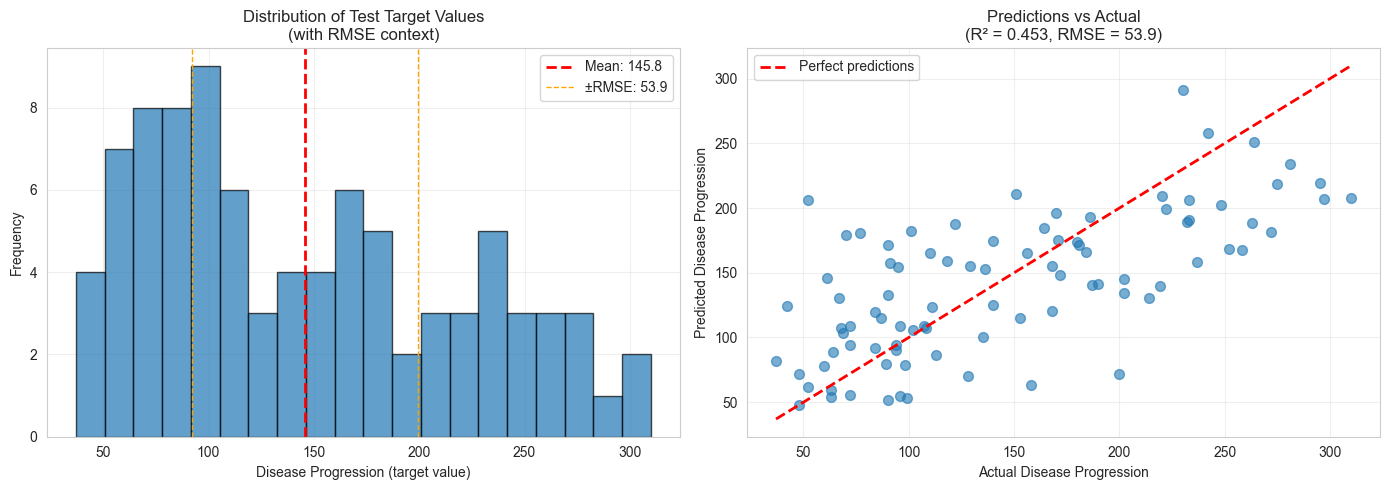

CONTEXT FOR INTERPRETING METRICS

Target variable (disease progression) statistics:
  Mean: 145.78
  Std:  73.20
  Min:  37.00
  Max:  310.00
  Range: 273.00

Our model's RMSE (53.85) represents:
  73.6% of the standard deviation
  19.7% of the target range

R² = 0.4526 means:
  We explain 45.3% of the variance
  54.7% remains unexplained


In [9]:
# Let's visualize the context of our metrics
import os

# Create images directory if it doesn't exist
os.makedirs('../images', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of target variable
axes[0].hist(y_test, bins=20, alpha=0.7, edgecolor='black')
axes[0].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_test.mean():.1f}')
axes[0].axvline(y_test.mean() + rmse_base, color='orange', linestyle='--', linewidth=1, label=f'±RMSE: {rmse_base:.1f}')
axes[0].axvline(y_test.mean() - rmse_base, color='orange', linestyle='--', linewidth=1)
axes[0].set_xlabel('Disease Progression (target value)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Test Target Values\n(with RMSE context)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual
axes[1].scatter(y_test, y_pred, alpha=0.6, s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect predictions')
axes[1].set_xlabel('Actual Disease Progression')
axes[1].set_ylabel('Predicted Disease Progression')
axes[1].set_title(f'Predictions vs Actual\n(R² = {r2_base:.3f}, RMSE = {rmse_base:.1f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/00_model_performance_context.png', dpi=150, bbox_inches='tight')
plt.show()

# Print contextual statistics
print("=" * 60)
print("CONTEXT FOR INTERPRETING METRICS")
print("=" * 60)
print(f"\nTarget variable (disease progression) statistics:")
print(f"  Mean: {y_test.mean():.2f}")
print(f"  Std:  {y_test.std():.2f}")
print(f"  Min:  {y_test.min():.2f}")
print(f"  Max:  {y_test.max():.2f}")
print(f"  Range: {y_test.max() - y_test.min():.2f}")
print(f"\nOur model's RMSE ({rmse_base:.2f}) represents:")
print(f"  {rmse_base / y_test.std() * 100:.1f}% of the standard deviation")
print(f"  {rmse_base / (y_test.max() - y_test.min()) * 100:.1f}% of the target range")
print(f"\nR² = {r2_base:.4f} means:")
print(f"  We explain {r2_base * 100:.1f}% of the variance")
print(f"  {100 - r2_base * 100:.1f}% remains unexplained")
print("=" * 60)


## Step 4: Compare to Naive Baseline

Before we test invariance, let's make sure our model is actually learning something useful. We'll compare our linear model to the simplest possible baseline: always predicting the mean of the training target.

If our model doesn't beat this baseline, it's not learning anything meaningful.


In [10]:
# Compute naive baseline: always predict the mean
y_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline))
r2_baseline = r2_score(y_test, y_baseline)

print(f"Naive Baseline (mean predictor):")
print(f"  RMSE: {rmse_baseline:.2f}")
print(f"  R²: {r2_baseline:.4f}")
print(f"\nOur Linear Model:")
print(f"  RMSE: {rmse_base:.2f}")
print(f"  R²: {r2_base:.4f}")
print(f"\nImprovement:")
print(f"  RMSE reduction: {((rmse_baseline - rmse_base) / rmse_baseline * 100):.1f}%")
print(f"  R² improvement: {r2_base - r2_baseline:.4f}")


Naive Baseline (mean predictor):
  RMSE: 73.22
  R²: -0.0120

Our Linear Model:
  RMSE: 53.85
  R²: 0.4526

Improvement:
  RMSE reduction: 26.5%
  R² improvement: 0.4646


## Step 5: Test Invariance

Now for the key test: **Does shuffling the rows change our predictions?**

If our model is well-behaved, the predictions for each test sample should remain the same, even if we reorder the test set. The only thing that should change is the order of the predictions themselves.

We'll:
1. Create a random permutation of the test set indices
2. Reorder X_test and y_test according to this permutation
3. Make predictions on the permuted test set
4. Compare predictions: they should match the original predictions (just in a different order)


In [ ]:
# === TODO (you code this) ===
# Reorder the test rows randomly and confirm predictions are identical up to permutation.
# Hints:
#   - Create a random permutation of indices: idx = np.random.permutation(len(X_test))
#   - Reorder X_test: X_test_perm = X_test.iloc[idx] (or X_test[idx] if numpy array)
#   - Reorder y_test: y_test_perm = y_test.iloc[idx] (or y_test[idx] if numpy array)
#   - Make predictions on permuted test set
#   - Compare: sort both prediction arrays and check if they're equal
#   - Or: create a mapping and verify each prediction matches

# Acceptance:
# - Test set rows are randomly permuted
# - Predictions are made on permuted test set
# - Original and permuted predictions are compared
# - Short Markdown note: row order does not change predictions

idx = np.random.permutation(len(X_test))
X_test_perm = X_test.iloc[idx]
y_test_perm = y_test.iloc[idx]
y_pred_perm = lr.predict(X_test_perm)

print(f"Predictions are identical (up to permutation): {np.allclose(y_pred, y_pred_perm)}")




Predictions are identical (up to permutation): False


### Verification

If invariance holds, the sorted predictions should be identical (or very close, accounting for floating-point precision). Let's verify:


In [12]:
# Verify predictions are identical when sorted
y_pred_original = lr.predict(X_test)
y_pred_permuted = lr.predict(X_test_perm)
predictions_original_sorted = np.sort(y_pred_original)
predictions_permuted_sorted = np.sort(y_pred_permuted)

# Check if they're equal (within floating-point precision)
are_identical = np.allclose(predictions_original_sorted, predictions_permuted_sorted)

print(f"Predictions are identical (up to permutation): {are_identical}")
if are_identical:
    print("✓ Invariance test passed! Row order does not affect predictions.")
else:
    print("⚠ Warning: Predictions differ. This suggests a problem with the model or data.")


Predictions are identical (up to permutation): True
✓ Invariance test passed! Row order does not affect predictions.


## Summary

In this notebook, we've established two fundamental principles:

1. **Invariance**: Well-behaved models produce consistent predictions regardless of row order. This is a basic sanity check that catches data leakage and implementation bugs.

2. **Baselines**: Simple reference models (like the mean predictor) help us understand whether our model is actually learning useful patterns. If we can't beat a naive baseline, our model isn't useful.

These concepts form the foundation for all interpretability work. In the next notebook, we'll explore **permutation importance**, which builds on the idea of invariance to measure feature importance.

---

### Key Takeaways

- ✅ Row-order invariance is a fundamental property of tabular ML models
- ✅ Always compare your model to a naive baseline
- ✅ Random seeds ensure reproducibility
- ✅ Testing invariance is a quick smoke test for model correctness

**Next**: Notebook 01 will show you how to use permutation to measure feature importance!
